# Grid tuning
## 10 km grid
Several grid modifications to e.g. enhance numerical stability. Starting point for this notebook are the grid files in ../data/preprocessing/interim, which have been generated using the ../src/preprocessing/grid/make_grid.m script.

First, lets generate a copy in ../data/preprocessing/processed/ to work on this copy.

In [13]:
import sys
import os
from shutil import copyfile, move
prep_dir = os.path.join(os.pardir,'data','preprocessing')
grd_old = os.path.join(prep_dir,'interim','waom10_MinDepth20m_rx10.3_grd.nc')
grd_new = os.path.join(prep_dir,'processed','waom10_grd.nc')
copyfile(grd_old,grd_new)

'../data/preprocessing/processed/waom10_grd.nc'

## Set water column thickness to >= 50m: South of -60S by artificially deepen the bathymetry; north of -60S by masking
The model tends to blow up in shallow ice cavity regions due to to thin vertical layers.
Deepen the bathy ensures certain vertical level thickness while preserving important deep ice shelf parts of the cavity.

In [14]:
import numpy as np
from netCDF4 import Dataset

def deepen_bathy(grid_file,min_depth):
    
    id = Dataset(grid_file,'a')
    h_old = id.variables['h'][:,:]
    zice = id.variables['zice'][:,:]
    lat = id.variables['lat_rho'][:,:]
    mask_old = id.variables['mask_rho'][:,:]
    nbModif = 0
    nbModif_mask = 0
  # calculate watercolumn thickness and mask with land mask
    wc = h_old + zice
    h_new=h_old.copy()
    mask_new = mask_old.copy()
    for iEta in range(np.size(h_old,0)):
        for iXi in range(np.size(h_old,1)):
            if (mask_old[iEta,iXi]==1 and lat[iEta,iXi] <= -60.0 and wc[iEta,iXi]<min_depth):
                h_new[iEta,iXi] = h_old[iEta,iXi] + (min_depth - wc[iEta,iXi])
                nbModif += 1
                
            elif (mask_old[iEta,iXi]==1 and lat[iEta,iXi] > -60.0 and wc[iEta,iXi]<min_depth):
                mask_new[iEta,iXi]==0
                nbModif_mask+=1

    print('     nbModif=', nbModif)
    print('     nbModif_mask=',nbModif_mask)

    id.variables['h'][:,:]= h_new
    id.variables['mask_rho']= mask_new
        
    id.close()

In [15]:
deepen_bathy(grd_new,50)

     nbModif= 3574
     nbModif_mask= 776


## Mask isolated cells
Some ocean cells are surrounded by just land cells. Find these and mask them out.

In [16]:
from netCDF4 import Dataset
from numpy import *

# Find all of the CICE grid points which are land (or ice shelf) on 3 sides.
# Sea ice can grow in these isolated points but cannot escape due to CICE's
# coastal boundary conditions, so it gets crazy thick (like 2 km thick).
# Print the indices of these points to the screen. This script assumes a
# periodic boundary in the longitude direction.
# Input: cice_kmt_file = path to CICE land mask file, created using cice_grid.py
def find_isolated_points (grd_file):

    # Read land mask
    id = Dataset(grd_file, 'a')
    mask_old = id.variables['mask_rho'][:,:]
    mask_new = mask_old.copy()
    nb_modif=0

    # Double loop, can't find a cleaner way to do this
    for j in range(1,size(mask_old,0)-1):
        for i in range(1,size(mask_old,1)-1):
            # Check for unmasked points
            if mask_old[j,i] == 1:
                neighbours = array([mask_old[j,i-1], mask_old[j,i+1], mask_old[j-1,i], mask_old[j+1,i]])
                # Blocked on at least 3 sides
                if sum(neighbours) < 1:
                    #print("i=" + str(i+1) + ', j=' + str(j+1))
                    mask_new[j,i]=0
                    nb_modif+=1
    print("number modified = ", nb_modif)

    umask,vmask,pmask=uvp_masks(mask_new)
    
    id.variables['mask_rho'][:,:]= mask_new
    id.variables['mask_u'][:,:]= umask
    id.variables['mask_v'][:,:]= vmask
    id.variables['mask_psi'][:,:]= pmask
    id.close()

def uvp_masks(rmask):
    '''
    return u-, v-, and psi-masks based on input rho-mask
    
    Parameters
    ----------
    
    rmask : ndarray
        mask at CGrid rho-points
    
    Returns
    -------
    (umask, vmask, pmask) : ndarrays
        masks at u-, v-, and psi-points
    '''
    rmask = asarray(rmask)
    assert rmask.ndim == 2, 'rmask must be a 2D array'
    assert all((rmask==0)|(rmask==1)), 'rmask array must contain only ones and zeros.'

    umask = rmask[:, :-1] * rmask[:, 1:]
    vmask = rmask[:-1, :] * rmask[1:, :]
    pmask = rmask[:-1, :-1] * rmask[:-1, 1:] * rmask[1:, :-1] * rmask[1:, 1:]

    return umask, vmask, pmask

In [17]:
find_isolated_points(grd_new)

number modified =  84


## Mask isolated ice shelf points where model tends to blow up
shift the masking boxes in dependence to grid expansion

In [18]:
import numpy as np
from netCDF4 import Dataset

def mask_box(grid_file,box):
    
    id = Dataset(grid_file,'a')
    zice = id.variables['zice'][:,:]
    mask_old = id.variables['mask_rho'][:,:]
    mask_new = mask_old.copy()
    nbModif = 0

    [imin,jmin,imax,jmax]=box
    imax=imax+1
    jmax=jmax+1

    for iEta in range(jmin,jmax):
        for iXi in range(imin,imax):
            if (mask_old[iEta,iXi]==1 and zice[iEta,iXi]<0.0):
                mask_new[iEta,iXi] = 0
                nbModif += 1

    print('     nbModif=', nbModif)


    umask,vmask,pmask=uvp_masks(mask_new)

    id.variables['mask_rho'][:,:]= mask_new
    id.variables['mask_u'][:,:]= umask
    id.variables['mask_v'][:,:]= vmask
    id.variables['mask_psi'][:,:]= pmask
        
    id.close()

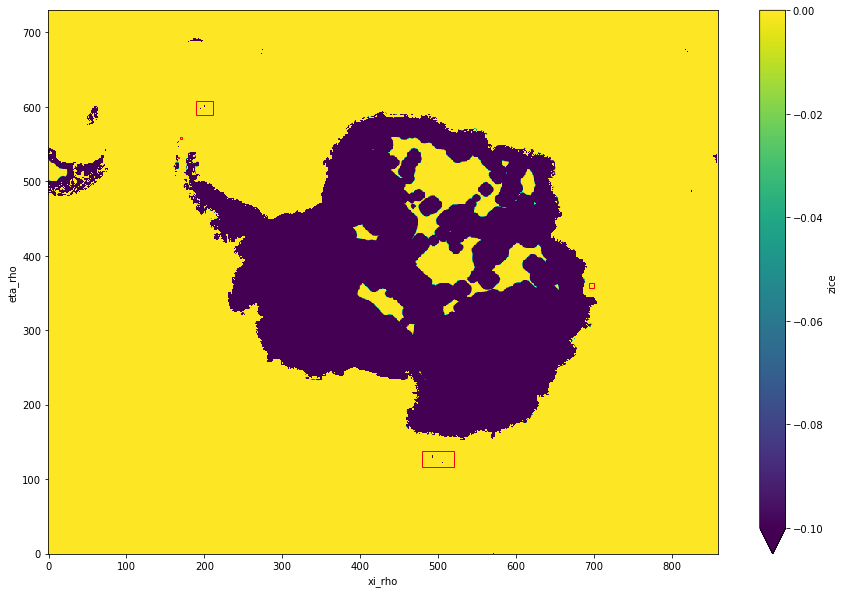

In [19]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import xarray as xr

# boxes for small grid [imin,jmin,imax,jmax]

box1=np.array([481,117,520,137])
box2=np.array([190,590,210,607])
box3=np.array([167,532,167,532])
box4=np.array([170,558,170,558])
box5=np.array([695,357,699,362])


box_list = [box1,box2,box3,box4,box5]

grd_ds = xr.open_dataset(grd_new)

#print(box_copy_list)
    
plt.close()
fig,ax1=plt.subplots(figsize=(15,10))
grd_ds.zice.plot(ax=ax1,vmin=-0.1)

# first show the boxes
for box in box_list:

    ax1.add_patch(Rectangle((box[0]-1, box[1]-1), box[2]-box[0]+2, box[3]-box[1]+2, fill=False,color="r"))

plt.show()

In [20]:
# then do the masking
for box in box_list:
    mask_box(grd_new,box)

     nbModif= 4
     nbModif= 6
     nbModif= 1
     nbModif= 1
     nbModif= 1


## Mask out lonely cells in south america and tassi
Patagonia and Tassi feature some lakes that make trouble and I'm not interested in. Mask anything that's not smooth there.
### 1. Mask box in land areas, which makes things easier later

In [21]:
def mask_box(grid_file,box):

    id = Dataset(grid_file,'a')
    zice = id.variables['zice'][:,:]
    mask_old = id.variables['mask_rho'][:,:]
    mask_new = mask_old.copy()
    nbModif = 0

    [imin,jmin,imax,jmax]=box
    imax=imax+1
    jmax=jmax+1

    for iEta in range(jmin,jmax):
        for iXi in range(imin,imax):
            if (mask_old[iEta,iXi]==1):
                mask_new[iEta,iXi] = 0
                nbModif += 1

    print('     nbModif=', nbModif)


    umask,vmask,pmask=uvp_masks(mask_new)

    id.variables['mask_rho'][:,:]= mask_new
    id.variables['mask_u'][:,:]= umask
    id.variables['mask_v'][:,:]= vmask
    id.variables['mask_psi'][:,:]= pmask

    id.close()

In [22]:
box1=np.array([39,503,47,511])
box2=np.array([858,525,859,529])

for box in [box1,box2]:
    mask_box(grd_new,box)

     nbModif= 46
     nbModif= 2


### 2. define boxes and modify the find_isolated_points algorithm to be used in certain area and with flexibile neigbhour mask points restriction

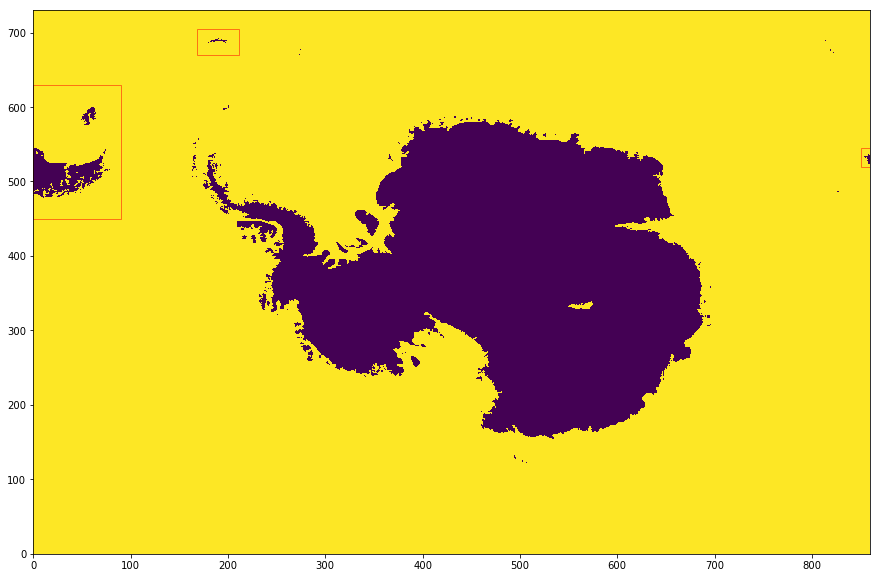

In [23]:
id=Dataset(grd_new,'r')
mask=id.variables['mask_rho'][:,:]
zice=id.variables['zice'][:,:]
id.close()

# boxes for small grid [imin,jmin,imax,jmax]
box1=np.array([0,450,90,630])
box2=np.array([850,520,860,545])
box3=np.array([168,670,211,705])
box4=np.array([545,325,583,347]) #vostock for later

box_list=[box1,box2,box3]
plt.close()
fig,ax=plt.subplots(figsize=(15,10))
mask_plt=ax.pcolormesh(mask)
#ice_plt=ax.pcolormesh(zice,vmin=-0.1,alpha=0.3,cmap='bwr')

# first show the boxes
for box in box_list:
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False,color="r",alpha=0.5))
plt.show()

In [24]:
def find_isolated_points (grd_file,box,nb):

    # Read land mask
    id = Dataset(grd_file, 'a')
    mask_old = id.variables['mask_rho'][:,:]
    mask_new = mask_old.copy()
    nb_modif=0

    # Double loop over box area, can't find a cleaner way to do this
    for j in np.arange(box[1],box[3]-1):
        for i in np.arange(box[0],box[2]-1):
            # Check for unmasked points
            if mask_old[j,i] == 1:
                neighbours = np.array([mask_old[j,i-1], mask_old[j,i+1], mask_old[j-1,i], mask_old[j+1,i]])
                # Blocked on at least 3 sides
                if np.sum(neighbours) < nb:
                    #print("i=" + str(i+1) + ', j=' + str(j+1))
                    mask_new[j,i]=0
                    nb_modif+=1
    print("number modified = ", nb_modif)

    umask,vmask,pmask=uvp_masks(mask_new)
    
    id.variables['mask_rho'][:,:]= mask_new
    id.variables['mask_u'][:,:]= umask
    id.variables['mask_v'][:,:]= vmask
    id.variables['mask_psi'][:,:]= pmask
    id.close()

    return nb_modif

### 3. In all boxes mask isolated points, which have less then 2 ocean neighbours

In [33]:
for box in box_list:
    nb_modif = np.inf
    while nb_modif != 0:
        nb_modif = find_isolated_points(grd_new,box,2)

number modified =  0
number modified =  0
number modified =  0


### 4. In south america, mask isolated points, which have less then 3 ocean neighbours

In [34]:
nb_modif = find_isolated_points(grd_new,box1,3)

number modified =  105


### Plot result and repeat step 3. followed by 4. until satisfied (all lakes on south america masked)

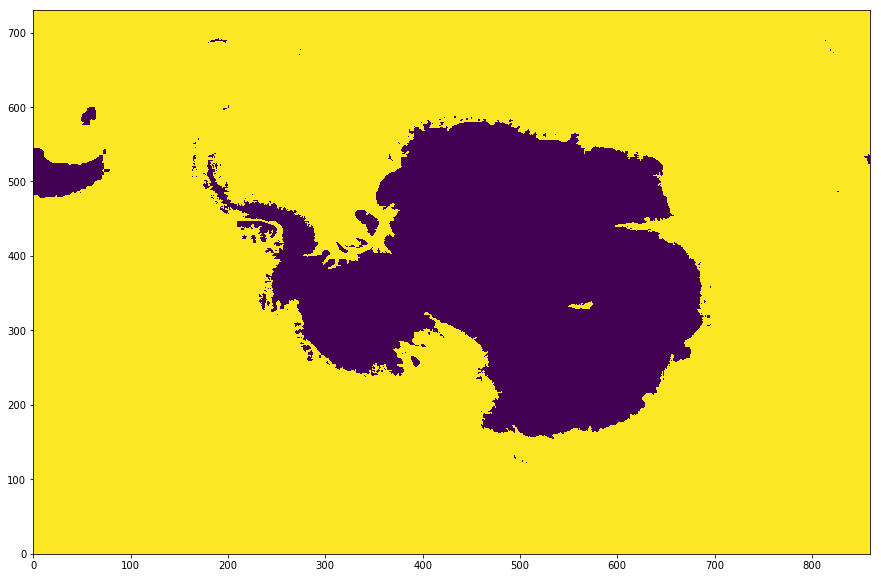

In [35]:
plt.close()
id=Dataset(grd_new,'r')
mask=id.variables['mask_rho'][:,:]
zice=id.variables['zice'][:,:]
id.close()

fig,ax=plt.subplots(figsize=(15,10))
mask_plt=ax.pcolormesh(mask)

plt.show()

## Smooth the deep ocean
Smooth everything below 2000m or north of -60S and not mask. 
I do so by lifting the bathy and conserv volume to obey rx0max = 0.2 ... soft smoothing

In [36]:
import os
import sys

# add the 'src/' directory as one where we can import modules
src_dir = os.path.join(os.pardir,'src')
sys.path.append(src_dir)

from features.smooth_bathy import smoothing_PlusMinus_rx0

from features.cartesian_grid_2d import cartesian_grid_2d

ploting = True

id=Dataset(grd_new,'r')
zice = id.variables['zice'][:,:]
h=id.variables["h"][:,:]
mask_rho = id.variables['mask_rho'][:,:]
lon_u = id.variables['lon_u'][:,:]
lon_v = id.variables['lon_v'][:,:]
lat_u = id.variables['lat_u'][:,:]
lat_v = id.variables['lat_v'][:,:]
lat_rho = id.variables["lat_rho"][:,:]
id.close()

mask_deep = np.where(h>=2000.0,1,0)
mask_north = np.where(lat_rho>=-60.0,1,mask_deep)
mask = np.where(mask_rho==0,0,mask_north)

zice_new = np.where(lat_rho)

dx,dy=cartesian_grid_2d(lon_u,lat_u,lon_v,lat_v)
area=dx*dy

h_tmp = h.copy()

h_tmp, HmodifVal, ValueFct=smoothing_PlusMinus_rx0(mask,h_tmp,0.2,area)
print(HmodifVal, ValueFct)

     nbModif= 5413
     nbModif= 3023
     nbModif= 2948
     nbModif= 2955
     nbModif= 2958
     nbModif= 2956
     nbModif= 2964
     nbModif= 2967
     nbModif= 2975
     nbModif= 2971
     nbModif= 2954
     nbModif= 2913
     nbModif= 2820
     nbModif= 2627
     nbModif= 2286
     nbModif= 2207
     nbModif= 2200
     nbModif= 2186
     nbModif= 2180
     nbModif= 2175
     nbModif= 2166
     nbModif= 2153
     nbModif= 2144
     nbModif= 2118
     nbModif= 2037
     nbModif= 1899
     nbModif= 1741
     nbModif= 1661
     nbModif= 1639
     nbModif= 1636
     nbModif= 1631
     nbModif= 1626
     nbModif= 1621
     nbModif= 1616
     nbModif= 1608
     nbModif= 1602
     nbModif= 1575
     nbModif= 1511
     nbModif= 1438
     nbModif= 1340
     nbModif= 1258
     nbModif= 1221
     nbModif= 1199
     nbModif= 1190
     nbModif= 1188
     nbModif= 1184
     nbModif= 1176
     nbModif= 1174
     nbModif= 1173
     nbModif= 1170
     nbModif= 1155
     nbModif= 1139
     nbModif

## Masking shallow again
some coastal points might be shallower than 50 m now. mask them out

In [37]:
# some coastal points might be shallower than 50 m now. mask them out
wc=h_tmp+zice
print(any(wc<49))
mask_shallow=np.where(wc<49.999,0,mask_rho)
h_masked = ma.masked_where(mask_shallow==0,h_tmp)
wc_masked=ma.masked_where(mask_shallow==0,h_masked-zice)
print(any(wc_masked<50.0))
print(amin(wc))
print(amin(wc_masked))

True
False
0.0999999999999
50.0


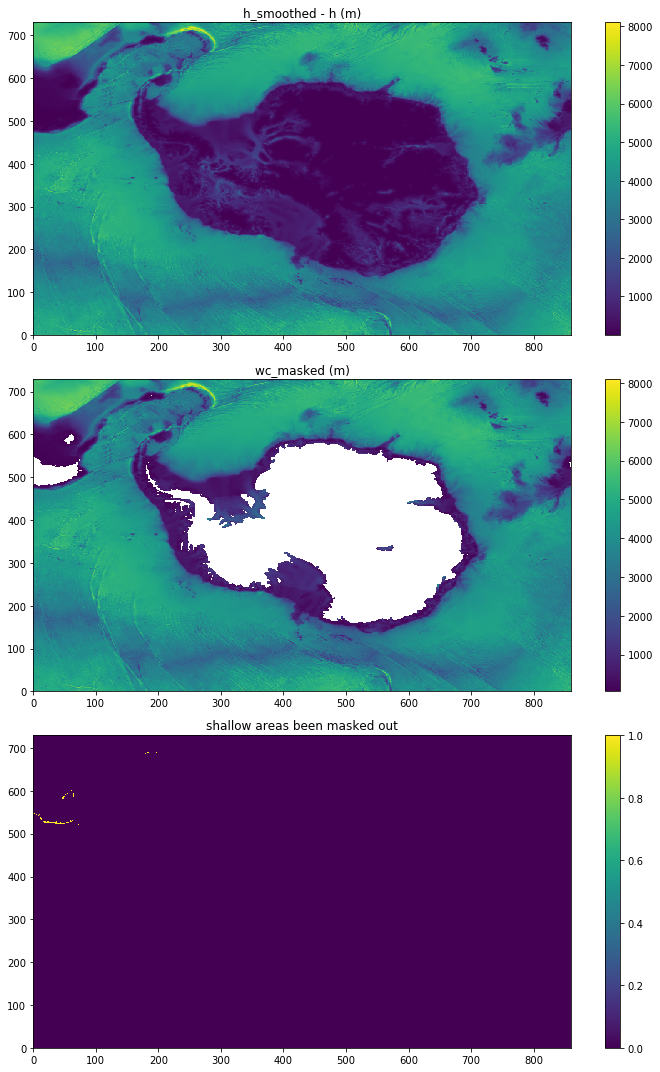

In [57]:
#some checkup plots
plt.close()
fig3 ,(ax1,ax2,ax3)=plt.subplots(3,figsize=(10,15))
im=ax1.pcolormesh(h_tmp)
plt.colorbar(im,ax=ax1)
ax1.set_title("h_smoothed - h (m)")

im2=ax2.pcolormesh(wc_masked)
plt.colorbar(im2,ax=ax2)
ax2.set_title("wc_masked (m)")
#ax2.contour(mask)

im3=ax3.pcolormesh(mask_rho - mask_shallow)
plt.colorbar(im3,ax=ax3)
ax3.set_title("shallow areas been masked out")
fig3.tight_layout()

plt.show()

## Mask zice above 65S

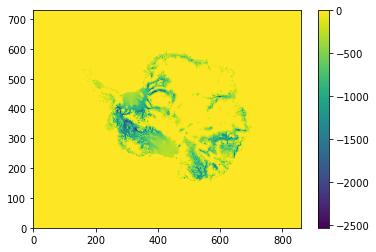

In [54]:
mask_58 = np.where(lat_rho>=-60,0.0,1.0)
zice_new=zice*mask_58
plt.close()
plt.pcolormesh(zice_new)
plt.colorbar()
plt.show()

## Update bathymetry zice and masks
fill in the fucking mask in the bathymetry and co!!! ROMS cant handle NaN's
... you simply do this by writing h_tmp.data instead of the masked array.

In [46]:
umask,vmask,pmask=uvp_masks(mask_shallow)

In [66]:
print(type(vmask))
isnan(vmask).any()

<class 'numpy.ndarray'>


False

In [67]:
#update bathy and masks in netcdf file
id = Dataset(grd_new,'a')
id.variables['h'][:,:]=h_tmp
id.variables['mask_rho'][:,:]=mask_shallow
id.variables["zice"][:,:]=zice_new
id.variables['mask_u'][:,:]= umask
id.variables['mask_v'][:,:]= vmask
id.variables['mask_psi'][:,:]= pmask
id.close()

## add sponge layer

In [68]:
from features.add_sponge import add_sponge
viscFac=100
diffFac=50

add_sponge(grd_new,viscFac,diffFac)

Reading grid.
Setting up visc and diff Factor arrays.
Writing arrays out to grid file.


## Optional: Increase DT by buldozer far north regions with hard smoothing approach
... smooth north of -60.0S by lifting bathy, conserve volume until you obey rx0max = 0.1
check for wc <50 and mask and apply mask to uvpsi and fill in mask_rho points when you write out h!

In [67]:
from netCDF4 import Dataset
from numpy import *
from matplotlib.pyplot import *

id=Dataset(grd_list[0],'r')
h=id.variables["h"][:,:]
zice=id.variables['zice'][:,:]
mask_rho = id.variables['mask_rho'][:,:]
lon_u = id.variables['lon_u'][:,:]
lon_v = id.variables['lon_v'][:,:]
lat_u = id.variables['lat_u'][:,:]
lat_v = id.variables['lat_v'][:,:]
lat_rho = id.variables['lat_rho'][:,:]
lon_rho = id.variables['lon_rho'][:,:]
id.close()
#mask_deep = np.where(h>=2000.0,1,0)
mask_north = np.where(lat_rho>=-60.0,1,0)
mask = np.where(mask_rho==0,0,mask_north)

#fig = figure(figsize=(12,8))
#pcolormesh(mask)
#colorbar()
#contour(lat_rho,arange(-60,-50))
#colorbar()

dx,dy=cartesian_grid_2d(lon_u,lat_u,lon_v,lat_v)
area=dx*dy

h_tmp = h.copy()

print("smoothing")

h_tmp, HmodifVal, ValueFct=smooth_bathy.smoothing_PlusMinus_rx0(mask,h_tmp,0.15,area)
print(HmodifVal, ValueFct)        


smoothing
     nbModif= 251
     nbModif= 111
     nbModif= 109
     nbModif= 105
     nbModif= 105
     nbModif= 105
     nbModif= 105
     nbModif= 105
     nbModif= 105
     nbModif= 103
     nbModif= 103
     nbModif= 103
     nbModif= 101
     nbModif= 85
     nbModif= 56
     nbModif= 35
     nbModif= 35
     nbModif= 35
     nbModif= 35
     nbModif= 35
     nbModif= 35
     nbModif= 35
     nbModif= 35
     nbModif= 35
     nbModif= 35
     nbModif= 34
     nbModif= 30
     nbModif= 20
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 7
     nbModif= 6
     nbModif= 4
     nbModif= 2
     nbModif= 1
     nbModif= 0
DeltaBathymetry =  0.0
0.000374426483588 65548.4065999


In [68]:
# some coastal points might be shallower than 50 m now. mask them out
wc=(h_tmp+zice)
print(any(wc<49))
mask_shallow=np.where(wc<49.999,0,mask_rho)
print(any(mask_shallow==mask_rho))
#h_masked = ma.masked_where(mask_shallow==0,h_tmp)
wc_masked=ma.masked_where(mask_rho==0,wc)
print(any(wc_masked<49))

True
True
False


In [69]:
print(amin(wc))
print(amin(wc_masked))

0.0999999999999
50.0


<IPython.core.display.Javascript object>


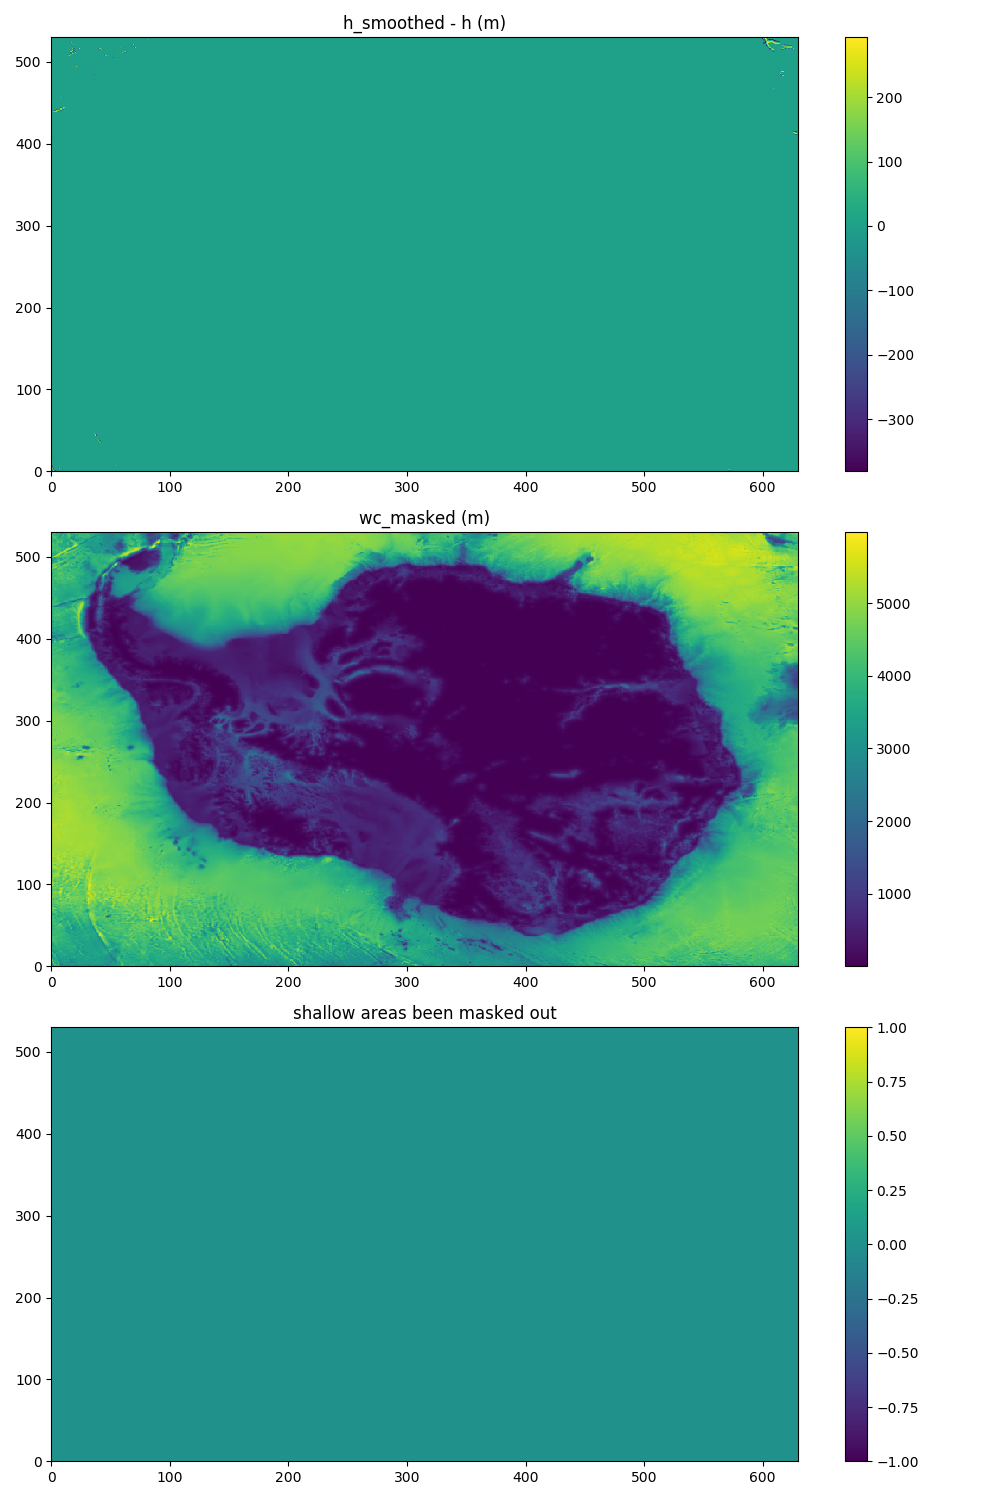

In [73]:
#some checkup plots

fig3 ,(ax1,ax2,ax3)=subplots(3,figsize=(10,15))
im=ax1.pcolormesh((h_tmp-h)*mask_rho)
colorbar(im,ax=ax1)
ax1.set_title("h_smoothed - h (m)")

im2=ax2.pcolormesh(h_tmp)
colorbar(im2,ax=ax2)
ax2.set_title("wc_masked (m)")
#ax2.contour(mask)

im3=ax3.pcolormesh(mask_shallow-mask_rho,vmin=-1,vmax=1)
colorbar(im3,ax=ax3)
ax3.set_title("shallow areas been masked out")
fig3.tight_layout()

# fill in the fucking mask in the bathymetry and co!!! ROMS cant handle NaN's
... you simply do this by writing h_tmp.data instead of the masked array.

In [72]:
umask,vmask,pmask=uvp_masks(mask_shallow)

In [75]:
#update bathy and masks in netcdf file
id = Dataset(grd_list[0],'a')
id.variables['h'][:,:]=h_tmp
id.variables['mask_rho'][:,:]=mask_shallow
#id.variables["zice"][:,:]=zice_new
id.variables['mask_u'][:,:]= umask
id.variables['mask_v'][:,:]= vmask
id.variables['mask_psi'][:,:]= pmask
id.close()

In [76]:
#copy straight to raijin to test grid
from shutil import move,copyfile
raijin_path="/home/ubuntu/raijin/short/m68/oxr581/ROMSIceShelf_devel/Data/waom10/waom10_grd.nc"
#move(grd_list[2],raijin_path)
print(grd_list[0],raijin_path)
copyfile(grd_list[0],raijin_path)

/home/ubuntu/bigStick/preprocessing/grdgen_mtb/waom10_orig_MinDepth20m_rx10.3_grd.nc_tmp2 /home/ubuntu/raijin/short/m68/oxr581/ROMSIceShelf_devel/Data/waom10/waom10_grd.nc


'/home/ubuntu/raijin/short/m68/oxr581/ROMSIceShelf_devel/Data/waom10/waom10_grd.nc'

# add angle to the grid file

read


<IPython.core.display.Javascript object>


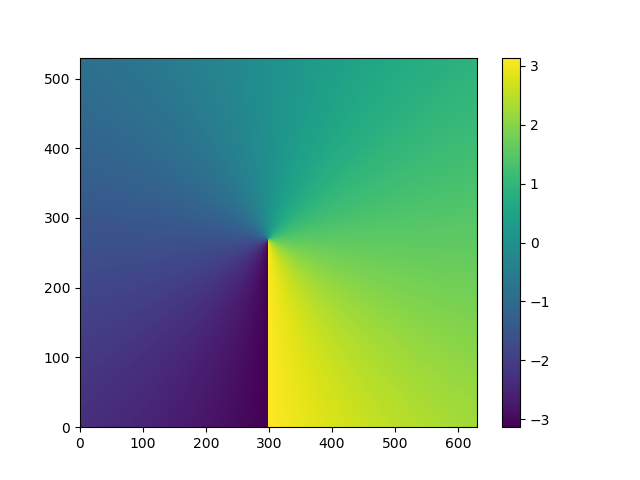

In [1]:
from netCDF4 import Dataset
from numpy import *
from matplotlib.pyplot import *
grd= '/home/ubuntu/raijin/short/m68/oxr581/ROMSIceShelf_devel/Data/waom10/waom10_grd.nc'
print('read')
id = Dataset(grd,'r')
lon=id.variables['lon_rho'][:,:]
id.close()
DTOR = pi/180.0
angle = lon*DTOR
%matplotlib notebook
pcolormesh(angle)
colorbar()


In [2]:
print("write")
id=Dataset(grd,'a')
id.variables['angle'][:,:]=angle[:,:]
#id.variables['angle'].long_name="angle ROMS xi axis is rotated anticlockwise from due east"
#id.variables['angle'].units="radians"
#id.variables['angle'].equation="u(roms)=Real((Ueast+i*Vnorth)*exp(-i*angle)) and v(roms)=Imag((Ueast+i*Vnorth)*exp(-i*angle))"
id.close()

write


In [ ]:
%matplotlib notebook
id=Dataset(raijin_path,'r')
zice = id.variables['zice'][:,:]
h=id.variables["h"][:,:]
mask_rho = id.variables['mask_rho'][:,:]
lon_u = id.variables['lon_u'][:,:]
lon_v = id.variables['lon_v'][:,:]
lat_u = id.variables['lat_u'][:,:]
lat_v = id.variables['lat_v'][:,:]
lat_rho = id.variables['lat_rho'][:,:]
lon_rho = id.variables['lon_rho'][:,:]
id.close()
print("plotting")
#some checkup plots
wc = h + zice
wc_ma = ma.masked_where(mask_rho==0,wc)
zice_ma = ma.masked_where(mask_rho==0,zice)
h_ma = ma.masked_where(mask_rho ==0,h)
print(any(wc<49))

fig3 ,ax1=subplots(1,figsize=(12,8))
im=ax1.pcolormesh(h_ma)
#ax1.contour(mask)
colorbar(im,ax=ax1)
ax1.set_title("h_smoothed - h (m)")
#im2=ax2.pcolormesh(zice,vmin=-10)
#colorbar(im2,ax=ax2)
#ax2.set_title("smoothed bathy (m)")
#ax2.contour(mask)
#im3=ax3.pcolormesh(wc,vmax=50,vmin=0)

#colorbar(im3,ax=ax3)
#ax3.set_title("smoothed wc (m)")
#fig3.tight_layout()


False


<IPython.core.display.Javascript object>


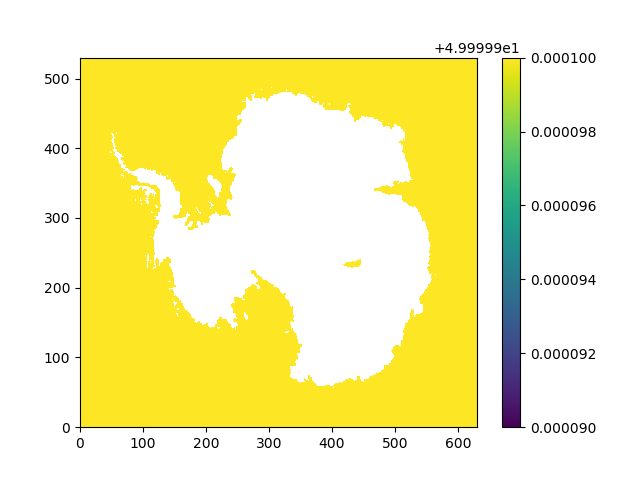

In [135]:
%matplotlib notebook
id=Dataset("/home/ubuntu/raijin/short/m68/oxr581/waom10_avg/Data/waom10/waom10_grd.nc",'r')
zice = id.variables['zice'][:,:]
h=id.variables["h"][:,:]
mask_rho = id.variables['mask_rho'][:,:]
lon_u = id.variables['lon_u'][:,:]
lon_v = id.variables['lon_v'][:,:]
lat_u = id.variables['lat_u'][:,:]
lat_v = id.variables['lat_v'][:,:]
lat_rho = id.variables['lat_rho'][:,:]
lon_rho = id.variables['lon_rho'][:,:]
id.close()
wc=h+zice
wc = ma.masked_where(mask_rho==0,wc)
print(any(wc<49.9))
pcolormesh(wc,vmin=49.99999,vmax=50.0)
colorbar()

## update grid_file, perhaps generate a new ini file and test again

In [103]:
#update bathy in netcdf file
id = Dataset(grd_list[2],'a')
id.variables['h'][:,:]=h_tmp
id.close()
#copy straight to raijin to test grid
from shutil import move,copy
raijin_path="/home/ubuntu/raijin/short/m68/oxr581/waom10_domain_study/Data/waom10/waom10_grd_large.nc"
#move(grd_list[2],raijin_path)
copy(grd_list[2],raijin_path)

'/home/ubuntu/raijin/short/m68/oxr581/waom10_domain_study/Data/waom10/waom10_grd_large.nc'

## move final versions of grid files into bigStick/waom10Grids/

In [64]:
# move final versions to bigStick/waom10Grids/
from shutil import move
grd_s_final ="/home/ubuntu/bigStick/waom10Grids/waom10_grd_small.nc"
grd_m_final ="/home/ubuntu/bigStick/waom10Grids/waom10_grd_medium.nc"
grd_l_final ="/home/ubuntu/bigStick/waom10Grids/waom10_grd_large.nc"

grd_list_final=[grd_s_final,grd_m_final,grd_l_final]
for i in arange(len(grd_list)):
    move(grd_list[i],grd_list_final[i])

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/bigStick/preprocessing/grdgen_mtb/waom10_small_MinDepth20m_rx10.3_grd.nc_tmp'

## 5 km grid
### mask ice north of 60 south
model blows up at isolated ice shelf points exposed to 